## Project Overview

This project is structured to provide hands-on experience in implementing a RAG system. Students will work through stages from dataset selection to connection to external artefacts (VectorDB, APIs), gaining a comprehensive understanding of RAG’s components and their integration.

### 1. Dataset Selection

Select a dataset suitable for your RAG application. Possible options include:
- **Learning Material**: A collection of books, slide decks on a specific topic
- **News articles**: A dataset containing articles on various topics.
- **Product Reviews**: Reviews of products along with follow-up responses.

**Bonus:** Consider using Multimodal datasets like text+images or text+audio

Check the end of this file for dataset examples

### 2. Exploratory Data Analysis (EDA)
Perform an EDA on the chosen dataset to understand its structure, content, and the challenges it presents. Document your findings and initial thoughts on how the data can be leveraged in a RAG system.

### 3. Embedding and Storing Chunks

#### 3.A Embed Your Chunks of Documents
- **Objective**: Transform your chunks of documents into embeddings that can be stored in a VectorDB.
- **Suggested Tool**: [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) (for English content).

**Bonus** Consider using the Embedding model from OpenAI, just be attentive to costs.

#### 3.B Connection to Vector DB
- **Objective**: Connect to a vector database to store and retrieve document embeddings.
- **Suggested Tool**: [ChromaDB](https://www.trychroma.com/).
- **Steps**:
  1. Pre-process the dataset to generate embeddings for each document using a suitable model (e.g., Sentence Transformers).
  2. Store these embeddings in ChromaDB.
  3. Implement retrieval logic to fetch relevant documents based on a query.

**Bonus:** Consider using a Cloud service to store your embeddings like Azure AI Search or Weaviate. Be attentive to potential costs.

#### 3.C AI Frameworks
- **Consider Using**: Frameworks like [LangChain](https://python.langchain.com/docs/integrations/vectorstores/chroma) and [LlamaIndex](https://gpt-index.readthedocs.io/en/latest/examples/vector_stores/ChromaIndexDemo.html) for easier integration.

### 4. Connecting to LLM
- **Objective**: Connect to a Large Language Model to generate responses based on retrieved documents.
- **Suggested Tool**: [OpenAI API](https://platform.openai.com/docs/api-reference/introduction).
- **Steps**:
  1. Set up access to the OpenAI API or an alternative LLM API.
  2. Develop the logic to combine retrieved documents with the query to generate a response.
  3. Implement and test the end-to-end RAG pipeline.

- **Bonus**: Connect to an API through a cloud service like AzureOpenAI, AWS Bedrock, or Google Vertex AI. Please note that the setup for this will be much more complex and not all might have a free tier model.

### 5. Evaluation
- **Objective**: Evaluate the performance of your RAG system in two ways.
  1. **Yourself**: Test the system multiple times to understand its performance and usability.
  2. **LLM as a judge (Bonus)**: Use an LLM as a judge to generate questions and evaluate your RAG's answers.
- **Steps**:
  1. Create a test set of queries and expected responses.
  2. Measure the performance of your RAG system against these queries.
  3. Analyze and document the strengths and weaknesses of your system.

### 6. Deployment (Bonus)
- **Objective**: Deploy the RAG system as a web application or API.
- **Tools**: Use frameworks like Flask or FastAPI for the backend and Streamlit for the frontend.
- **Steps**:
  1. Develop a simple web interface to interact with your RAG system.
  2. Deploy the application on a cloud platform such as AWS, GCP, or Heroku.


# EDA

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the correct folder
data_dir = "/content/drive/MyDrive/RAG_project_collab/elmundo_chunked_en_page1_15years"
files = os.listdir(data_dir)

print(f"Total files: {len(files)}")
print("Sample files:", files[:5])  # Preview first 5 files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total files: 821
Sample files: ['19200103_1.txt', '19200110_1.txt', '19200117_1.txt', '19200124_1.txt', '19200131_1.txt']


### File size check

In [ ]:
file_sizes = {file: os.path.getsize(os.path.join(data_dir, file)) for file in files}
print(f"Average file size: {sum(file_sizes.values()) / len(file_sizes):.2f} bytes")
print("Smallest files:", sorted(file_sizes.items(), key=lambda x: x[1])[:5])
print("Largest files:", sorted(file_sizes.items(), key=lambda x: x[1], reverse=True)[:5])

Average file size: 19882.52 bytes
Smallest files: [('19280901_1.txt', 6519), ('19280512_1.txt', 7693), ('19290202_1.txt', 8173), ('19281222_1.txt', 8391), ('19280602_1.txt', 8399)]
Largest files: [('19471206_1.txt', 33904), ('19470802_1.txt', 33606), ('19471004_1.txt', 33317), ('19461221_1.txt', 32961), ('19470419_1.txt', 32633)]


### Sampling Data

In [ ]:
def read_text_file(file_path, num_lines=15):
    with open(file_path, "r", encoding="utf-8") as f:
        return "\n".join([next(f) for _ in range(num_lines)])

sample_file = os.path.join(data_dir, files[0])
print(f"Contents of {files[0]}:\n", read_text_file(sample_file))

Contents of 19200103_1.txt:
 ELWNDO

8 pages 3 ctvs. Semester, $4.00 One year, $7.50

Offices: Salvador Brau. 81 Tel. 833 P. O. Box 345

NEWSPAPER OF THE TANGLE.

EXCEPT SUNDAYS

AKOU "S^=2==E======== == ^= ^z =====i======= ^ ======

SAN JUAN, PUERTO RICO. - 71 i. 1- ■- ■- r- - _¡

SATURDAY, JANUARY 3, 1920. r

i NUMBER 271.

ENTERED AS SECOND CLASS MATTER, FEBRUARY 21, 1919. AT THE POST OFFICE AT SAN JEAN. PORTO RICO. UNDER THE ACT OF MARCH 3, 1879.

Plot to assassinate the Prince of Serbia. 192,000 tons in dykes to be delivered by the Germans.

Peace already signed, the American site Hadarai in France.

! Excursion, banquet and ball in honor of the Congressmen.

A great fire ravages ios barracks at Nantes '>< filed with Che Port-J a-ter a* f-an Juan. P R. cn Jan. 2nd Mis, । . íoimwmg cablearas requtrZl t,.t Sts P. I I I 2 B P L 4 Beg. 1911, (P?r French Cable) v .^ ¡ NANTES. 2.- A most violent n ash, which could not be quenched with !The French government had recently acquired the can

### Text Length

In [ ]:
import numpy as np

file_lengths = []

for file in files:
    with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
        text = f.read()
        file_lengths.append(len(text.split()))  # Count words

print(f"Average words per file: {np.mean(file_lengths):.2f}")
print(f"Min words: {np.min(file_lengths)}, Max words: {np.max(file_lengths)}")

Average words per file: 3394.37
Min words: 1323, Max words: 5739


### Token and Vocabulary analysis

In [ ]:
from collections import Counter

word_counts = Counter()

for file in files[:100]:  # Limit to first 100 files for performance
    with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
        text = f.read().lower().split()
        word_counts.update(text)

print("Most common words:", word_counts.most_common(10))

Most common words: [('the', 24692), ('of', 13083), ('to', 7748), ('and', 6976), ('in', 6303), ('a', 4177), ('that', 3771), ('i', 3174), ('for', 2470), ('is', 2327)]


### Plot words

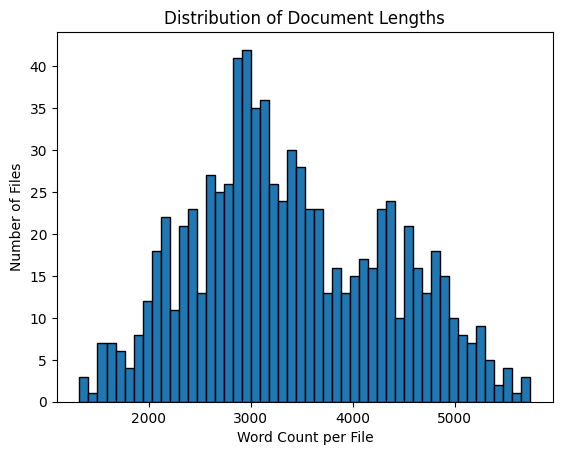

In [ ]:
import matplotlib.pyplot as plt

plt.hist(file_lengths, bins=50, edgecolor="black")
plt.xlabel("Word Count per File")
plt.ylabel("Number of Files")
plt.title("Distribution of Document Lengths")
plt.show()

# 2. Embedding

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory containing text files (Update the path as needed)
data_dir = "/content/drive/MyDrive/RAG_project_collab/elmundo_chunked_en_page1_15years"

# Check if the directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' not found. Please check your Google Drive path.")

# Read all text files and store content
documents = []
for file in os.listdir(data_dir):
    if file.endswith(".txt"):  # Ensure we only read text files
        with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
            documents.append(f.read())

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.create_documents(documents)

print(f"Successfully processed files from: {data_dir}")
print(f"📄 Total Chunks: {len(chunks)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully processed files from: /content/drive/MyDrive/RAG_project_collab/elmundo_chunked_en_page1_15years
📄 Total Chunks: 43445


# Create and Save chunks

In [ ]:
import numpy as np

batch_size = 256  # Adjust based on your system's memory
chunks = []
count = 0
for i in range(0, len(chunks), batch_size):
    batch = [chunk.page_content for chunk in chunks[i:i+batch_size]]
    batch_embeddings = model.encode(batch)  # Encode batch at once
    chunks.extend(batch_embeddings)
    count += 1
    print(f'Batch #: {count} complete.')

print("Embedding complete!")

In [ ]:
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Define a path to save embeddings in Google Drive
save_path = "/content/drive/MyDrive/RAG_project_collab/documents.npy"

# Convert embeddings to a NumPy array and save
chunks = np.array(chunks)
np.save(save_path, chunks)

print(f"🎉 Embeddings saved successfully at: {save_path}")


# Load Embeddings

In [ ]:
import os
import numpy as np
import chromadb
from google.colab import drive
from sentence_transformers import SentenceTransformer

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_folder = "/content/drive/MyDrive/RAG_project_collab"
documents_path = os.path.join(drive_folder, "documents.npy")  # Chunks of text

# Initialize the SentenceTransformer model (used to create embeddings)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load stored documents (chunks of text)
if os.path.exists(documents_path):
    documents = np.load(documents_path, allow_pickle=True).tolist()
    print(f"Loaded {len(documents)} documents from {documents_path}")
else:
    raise FileNotFoundError(f"Documents file not found: {documents_path}")

# Define ChromaDB path
chroma_db_path = os.path.join(drive_folder, "chroma_db")

# Check if ChromaDB exists
if os.path.exists(chroma_db_path):
    print(f"ChromaDB already exists at {chroma_db_path}")
    # Initialize ChromaDB client
    chroma_client = chromadb.PersistentClient(path=chroma_db_path)
    collection = chroma_client.get_or_create_collection(name="rag_documents")
else:
    print(f"ChromaDB not found. Creating a new ChromaDB at {chroma_db_path}")
    # Initialize ChromaDB client and create a new collection
    chroma_client = chromadb.PersistentClient(path=chroma_db_path)
    collection = chroma_client.get_or_create_collection(name="rag_documents")

    # Generate embeddings for the documents
    embeddings = model.encode(documents)  # Generate embeddings
    print(f"Generated {len(embeddings)} embeddings for documents.")

    # Ensure consistency before inserting
    if len(embeddings) != len(documents):
        raise ValueError("Mismatch between embeddings and documents!")

    # Insert documents and embeddings into ChromaDB
    batch_ids = [f"chunk_{i}" for i in range(len(documents))]
    batch_embs = [embedding.tolist() for embedding in embeddings]  # Convert to list format

    # Add the batch into the ChromaDB collection
    collection.add(ids=batch_ids, documents=documents, embeddings=batch_embs)
    print(f"Successfully stored {len(documents)} documents & embeddings into ChromaDB!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 43445 documents from /content/drive/MyDrive/RAG_project_collab/documents.npy
ChromaDB already exists at /content/drive/MyDrive/RAG_project_collab/chroma_db


# Retrieval based on query

In [ ]:
# Function to generate query embeddings
def get_query_embedding(query):
    """Generates the embedding for the query text."""
    return model.encode([query])[0]  # 'encode' expects a list, so we wrap query in a list

# Query the collection for relevant documents
query = "France"
query_embedding = get_query_embedding(query)  # Generate embedding for the query

# Search for the most similar documents in ChromaDB
results = collection.query(query_embeddings=[query_embedding.tolist()], n_results=5)

# Display the results
for result in results['documents']:
    print(result)

[None, 'who will lead France along the paths of order and freedom.', 'PARIS, May 20.-The situation between the governments of France and England is becoming more and more tense. The latest events highlight the domination exercised by the English with their diplomacy abroad, as well as their eternal predominance in European politics. Not yet satisfied with their security protected by the ocean, they now request the evacuation of Dusseldorf, Ruhrort, Duisbourg, and more than all that, the abolition of the customs cordon imposed by the French Republic on Germany.', '(By Cabio French) i PARIS, April 23.-A representative i of the newspaper "Le Matin** at the San Remo coni\' ferences ba been able to ente \' rse of a plan conceived by the je| fes of the governments of Ingla\'^errr. and i Italy. XJoyd George and Uitti, for the purpose of having Germany invited to take part in the sessions held there. This news has caused a deep sensation in Europe and great indignation in French circles. The r

# Connect to LLM

In [ ]:
import openai


# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your API key file in Google Drive
api_key_path = "/content/drive/MyDrive/RAG_project_collab/API_Key.txt"

try:
    # Check if the file exists
    if not os.path.exists(api_key_path):
        raise FileNotFoundError(f"API key file not found at: {api_key_path}")

    # Read the OpenAI API key from the file
    with open(api_key_path, "r") as file:
        openai_api_key = file.read().strip()  # Remove extra spaces/newlines

    # Ensure the key is not empty
    if not openai_api_key:
        raise ValueError("API key file is empty!")

    # Set the API key for OpenAI
    openai.api_key = openai_api_key
    print("OpenAI API key loaded successfully!")

except Exception as e:
    print(f"Error loading API key: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OpenAI API key loaded successfully!


In [ ]:
def combine_query_with_documents(query, documents):
    """Combine the query with retrieved documents to prepare a prompt."""
    prompt = f"Question: {query}\n\n"
    prompt += "Relevant Documents:\n"
    for idx, doc in enumerate(documents):
        prompt += f"{idx + 1}. {doc}\n"
    prompt += "\nAnswer the question based on the above documents."
    return prompt

In [24]:
# Example function for generating response from OpenAI LLM
def generate_response_from_openai(prompt):
    try:
        # Send the request to OpenAI's Chat API (Make sure to use the right model, e.g., gpt-3.5-turbo)
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # You can replace this with another model like "gpt-4"
            messages=[{"role": "user", "content": prompt}]
        )

        # Extract the response from the 'choices' attribute
        response_text = response.choices[0].message.content

        return response_text

    except Exception as e:
        print(f"Error in OpenAI API call: {e}")
        return None


def run_rag_pipeline(query):
    # 1. Retrieve relevant documents from ChromaDB
    query_embedding = get_query_embedding(query)
    results = collection.query(query_embeddings=[query_embedding.tolist()], n_results=5)
    retrieved_documents = results['documents']

    # 2. Combine the query with retrieved documents
    prompt = combine_query_with_documents(query, retrieved_documents)

    # 3. Generate response from OpenAI LLM
    response = generate_response_from_openai(prompt)

    return response



# Example query
query = "Why is France so influential in 1919?"
response = run_rag_pipeline(query)
print("Generated Response:", response)

Generated Response: France is influential in 1919 due to key leaders like Georges Clemenceau, who played a crucial role in the triumph of the Allies in the Great War. Clemenceau was known for leading France along the paths of order and freedom and was instrumental in the peace conference in 1919. Additionally, France's powerful and thriving status, along with strong liberal leadership, contributed to its influence in the post-war period. Clemenceau's strong stance against defeatism and his determination during the war further solidified France's influential position in 1919.
